In [1]:
# General useful imports
import array as ar
import contextlib
import wave
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio


from numpy import arange,linspace,mean, var, std, corrcoef, cov, transpose, ones,log,pi, sin, cos, exp, abs, angle, convolve
from numpy.random import random, randint, uniform
from scipy import signal
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab
# import plotly
from math import sqrt

%matplotlib inline

# Basic parameters for reading and writing mono wave files

numChannels   = 1                      # mono
sampleWidth   = 2                      # in bytes, a 16-bit short
SR            = 44100                  #  sample rate
MAX_AMP       = (2**(8*sampleWidth - 1) - 1)    #maximum amplitude is 2**15 - 1  = 32767
MIN_AMP       = -(2**(8*sampleWidth - 1))       #min amp is -2**15
windowWidth   = 4410
windowSlide   = 2205


def round4(x):
    return np.around(x,4)

def round2(x):
    return np.around(x,2)

# Basic Numpy statistical functions

X = np.array([1,2,3])       # just an example
Y = np.array([4,5,6])
             
# mean of a list
mean(X)                            

# Clip a signal or a scalar to upper and lower bounds, if not specified, us
# bounds provided above; will change the array in place and return it.
# Does NOT make a new copy. 

def clip(X,lo=MIN_AMP,hi=MAX_AMP):
    
    if type(X) != list and type(X) != np.ndarray:
        return max(min(X,hi),MIN_AMP)
    
    for k in range(len(X)):
        X[k] = max(min(X[k],MAX_AMP),MIN_AMP)
    return X

# To prevent clipping, this function takes a signal and rescales the amplitude
# (which must be given in relative units, in range 0 .. 1) so that 
#
#           max(X) = A * MAX_AMP
#

def scaleSignal(X,A=1.0):
        s = MAX_AMP*A/max(X)
        return np.array( [ x*s for x in X ] ).astype(int)

    
# create a signal from a spectrum represented as triples (freq,amp,phase)
# mode = 'absolute' (amplitude in spectrum is in range MIN_AMP .. MAX_AMP)
#      = 'relative' (amplitude in spectrum is in range 0 .. 1)
# if amp != None, will be resca

def makeSignal(S=[(220,1,0)], mode = 'relative', amp=None, duration=1):
    X = np.zeros(int(SR*duration)) 
    T = np.arange(int(SR*duration))
    if mode == 'relative':
        for (f,A,phi) in S:         
            X += MAX_AMP * A * np.sin( 2 * pi * f * T / SR + phi ) 
    else: # mode == 'relative'
        for (f,A,phi) in S:         
            X +=  A * np.sin( 2 * pi * f * T / SR + phi ) 
    if amp == None:
        return X.astype(int) 
    else:
        return (((X * MAX_AMP)/ max(X)) * amp).astype(int) 

# Some sample spectra
    
def makeSpectrum(instr,freq=220):
    if(instr=="triangle"):
        return ([(freq,1.0,0.0),    
        (freq*3,-1/(9),0.0), 
        (freq*5,1/(25),0.0), 
        (freq*7,-1/(49),0.0), 
        (freq*9,1/(81),0.0), 
        (freq*11,-1/(121),0.0), 
        (freq*13,1/(13*13),0.0)])
    elif(instr=="square"):
        return ([(freq,2/(np.pi),0.0), 
        (freq*3,2/(3*np.pi),0.0), 
        (freq*5,2/(5*np.pi),0.0), 
        (freq*7,2/(7*np.pi),0.0), 
        (freq*9,2/(9*np.pi),0.0), 
        (freq*11,2/(11*np.pi),0.0), 
        (freq*13,2/(13*np.pi),0.0),
        (freq*15,2/(15*np.pi),0.0),
        (freq*17,2/(17*np.pi),0.0),
        (freq*19,2/(19*np.pi),0.0),
        (freq*21,2/(21*np.pi),0.0)])
    elif(instr=="clarinet"):
        return ([(freq,0.314,0.0), 
        (freq*3,.236,0.0), 
        (freq*5,0.157,0.0), 
        (freq*7,0.044,0.0), 
        (freq*9,0.157,0.0), 
        (freq*11,0.038,0.0), 
        (freq*13,0.053,0.0)] ) 
    elif(instr=="bell"):
        return ([(freq,0.1666,0.0), 
        (freq*2,0.1666,0.0), 
        (freq*3,0.1666,0.0), 
        (freq*4.2,0.1666,0.0), 
        (freq*5.4,0.1666,0.0), 
        (freq*6.8,0.1666,0.0)])  
    elif(instr=="steelstring"):
        return ([(freq*0.7272, .00278,0.0),
        (freq, .0598,0.0),
        (freq*2, .2554,0.0),
        (freq*3, .0685,0.0),
        (freq*4, .0029,0.0),
        (freq*5, .0126,0.0),
        (freq*6, .0154,0.0),
        (freq*7, .0066,0.0),
        (freq*8, .0033,0.0),
        (freq*11.0455, .0029,0.0),
        (freq*12.0455, .0094,0.0),
        (freq*13.0455, .0010,0.0),
        (freq*14.0455, .0106,0.0),
        (freq*15.0455, .0038,0.0)])
    elif(instr=='organ'):
        return ([(freq*1, 0.16042589643241895, 0.0),
        (freq*2, 0.1655, 0.0),
        (freq*3, 0.0015, 0.0),
        (freq*3.9949, 0.02161, 0.0),
        (freq*5.9949, 0.04552, 0.0),
        (freq*7.9949, 0.0324, 0.0),
        (freq*9.9899, 0.00242, 0.0),
        (freq*11.9898, 0.0045, 0.0),
        (freq*17.9847, 0.0057, 0.0),
        (freq*19.9796, 0.0011, 0.0),
        (freq*27.9745, 0.0008, 0.0),
        (freq*29.9745, 0.0016, 0.0)]        
        )
    else:
        return []

# Piano key frequencies

notenames = ['A0', 'Bb0', 'B0', 'C1', 'C#1', 'D1', 'Eb1', 'E1', 'F1', 'F#1',
       'G1', 'Ab1', 'A1', 'Bb1', 'B1', 'C2', 'C#2', 'D2', 'Eb2', 'E2',
       'F2', 'F#2', 'G2', 'Ab2', 'A2', 'Bb2', 'B2', 'C3', 'C#3', 'D3',
       'Eb3', 'E3', 'F3', 'F#3', 'G3', 'Ab3', 'A3', 'Bb3', 'B3', 'C4',
       'C#4', 'D4', 'Eb4', 'E4', 'F4', 'F#4', 'G4', 'Ab4', 'A4', 'Bb4',
       'B4', 'C5', 'C#5', 'D5', 'Eb5', 'E5', 'F5', 'F#5', 'G5', 'Ab5',
       'A5', 'Bb5', 'B5', 'C6', 'C#6', 'D6', 'Eb6', 'E6', 'F6', 'F#6',
       'G6', 'Ab6', 'A6', 'Bb6', 'B6', 'C7', 'C#7', 'D7', 'Eb7', 'E7',
       'F7', 'F#7', 'G7', 'Ab7', 'A7', 'Bb7', 'B7', 'C8', 'R']

# Create chromatic scale, e.g., as on the piano, as a dictionary    

Freqs = {} 

f = 27.5

for name in notenames:
    Freqs[name] = f
    f *= 2**(1/12)

Freqs['R'] = 0                    # a rest (silence) 

# test

Freqs['C4']

from tqdm.notebook import trange, tqdm

In [2]:
# I/O for Wave files

# Read a mono wave file from a local file and return the entire file as a 1-D numpy array

def readWaveFile(infile,withParams=False,asNumpy=True):
    with contextlib.closing(wave.open(infile)) as f:
        params = f.getparams()
        frames = f.readframes(params[3])
        if(params[0] != 1):
            print("Warning in reading file: must be a mono file!")
        if(params[1] != 2):
            print("Warning in reading file: must be 16-bit sample type!")
        if(params[2] != 44100):
            print("Warning in reading file: must be 44100 sample rate!")
    if asNumpy:
        X = ar.array('h', frames)
        X = np.array(X,dtype='int16')
    else:  
        X = array.array('h', frames)
    if withParams:
        return X,params
    else:
        return X

# Write out an array as a wave file to the local directory
        
def writeWaveFile(X,fname):
    X = clip(X)
    params = [1,2, SR , len(X), "NONE", None]
    data = ar.array("h",X)
    with contextlib.closing(wave.open(fname, "w")) as f:
        f.setparams(params)
        f.writeframes(data.tobytes())
    print(fname + " written.")

In [3]:
def grab_peaks(X):
    peaks = []
    for i in range(1, len(X)-1):
#         if X[i-1] > (X[i]+0.01*X[i]) and X[i+1] > (X[i]+0.01*X[i]):
        if X[i-1] < X[i] and X[i+1] < X[i] and X[i] > 200:
            peaks.append(i)
    return peaks

In [4]:
def find_peaks(A,relative_threshold=0.75): 
    absolute_threshold = relative_threshold * max(A)    # or could assume highest value is at A[0]    
    peaks = []
    for t in range(3,len(A)-1):             
        if A[t-1] < A[t] and A[t] > A[t+1] and A[t] > absolute_threshold:
            peaks.append(t)
    return np.array(peaks)

## Copying in code from the [article](http://flothesof.github.io/cepstrum-pitch-tracking.html) for reference

[ 25  50  75 100 125 151]
441.43066406249994


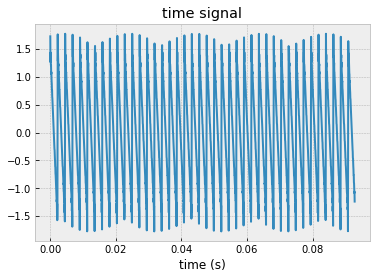

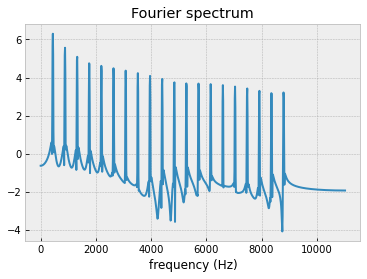

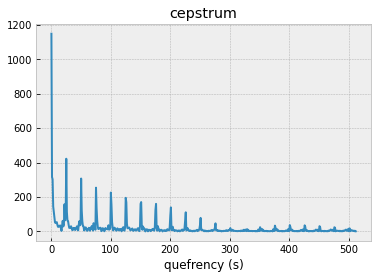

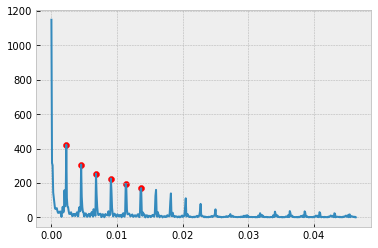

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

import numpy as np

def make_sine_wave(f0, sampling_frequency, frame_size, phase=0):
    """Generates a sine wave of frequency f0.
    
    :param f0: float, fundamental frequency
    :param sampling_frequency: int, number of samples per second
    :param frame_size: int, number of samples in frame
    :return:
        - waveform - ndarray of waveform
    """
    t = np.arange(frame_size) / sampling_frequency
    return np.sin(2 * np.pi * f0 * t + phase)


def make_harmonic_wave(f0, sampling_frequency, frame_size, n_harmonics=10):
    """Generates a 1/f weighted harmonic (multiples of f0) wave of frequency f0.
    
    :param f0: float, fundamental frequency
    :param sampling_frequency: int, number of samples per second
    :param frame_size: int, number of samples in frame
    :param n_harmonics: int, number of harmonics to add
    :return:
        - waveform - ndarray of waveform
    """
    waveform = np.zeros((frame_size,), dtype=float)
    for f in [f0 * i for i in range(1, n_harmonics + 1)]:
        waveform += f0 / f * make_sine_wave(f, sampling_frequency, frame_size, phase=f)
    return waveform

sample_freq = 22050 # Hz
frame_size = 2048
time_vector = np.arange(frame_size) / sample_freq
signal = make_harmonic_wave(440, sample_freq, frame_size, n_harmonics=20)

fig, ax = plt.subplots()
ax.plot(time_vector, signal)
ax.set_xlabel('time (s)')
ax.set_title('time signal')

windowed_signal = np.hamming(frame_size) * signal
dt = 1/sample_freq
freq_vector = np.fft.rfftfreq(frame_size, d=dt)
X = np.fft.rfft(windowed_signal)
log_X = np.log(np.abs(X))

fig, ax = plt.subplots()
ax.plot(freq_vector, log_X)
ax.set_xlabel('frequency (Hz)')
ax.set_title('Fourier spectrum')

cepstrum = np.fft.rfft(log_X)
cepstrum = np.abs(cepstrum)
df = freq_vector[1] - freq_vector[0]
quefrency_vector = np.fft.rfftfreq(log_X.size, df)

fig, ax = plt.subplots()
ax.plot(cepstrum)
ax.set_xlabel('quefrency (s)')
ax.set_title('cepstrum')

fig, ax = plt.subplots()
peaks = find_peaks(cepstrum[1:], relative_threshold=.4) # ignore first max
peaks += 1 # correction
peak_vals = [cepstrum[peak] for peak in peaks]
print(peaks)

ax.plot(quefrency_vector, cepstrum)
ax.scatter(quefrency_vector[peaks],peak_vals,color='r')

print(1/quefrency_vector[peaks[0]])

## Now my turn

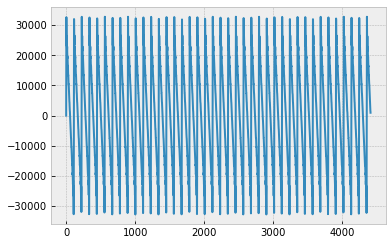

10.0
[217.51070803 217.92929498 206.32789061 ...   5.68964052  18.07901305
  24.96328924]


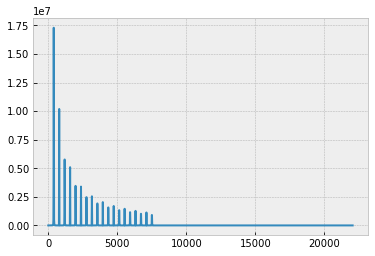

[5.38224808 5.38417068 5.32946661 ... 1.73864707 2.89475177 3.21740632]


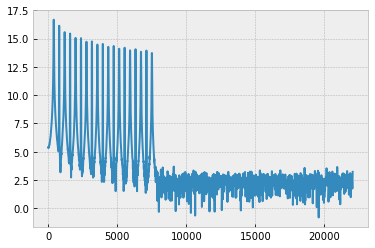

In [6]:
SR = 44100
def makeSignal(S=[(220,1,0)], mode = 'relative', amp=None, duration=1):
    X = np.zeros(int(SR*duration)) 
    T = np.arange(int(SR*duration))
    if mode == 'relative':
        for (f,A,phi) in S:         
            X += MAX_AMP * A * np.sin( 2 * pi * f * T / SR + phi ) 
    else: # mode == 'relative'
        for (f,A,phi) in S:         
            X +=  A * np.sin( 2 * pi * f * T / SR + phi ) 
    if amp == None:
        return X.astype(int)
    else:
        return (((X * MAX_AMP)/ max(X)) * amp).astype(int) 

f0 = 395
freqs = [(harm*f0, f0/(harm*f0), 0) for harm in range(1,20)]
X = makeSignal(freqs, duration=1/10, mode='relative', amp=1)
plt.plot(X)
plt.show()
X = np.hanning(len(X)) * X # window func
spect = np.fft.rfft(X)
spect = np.abs(spect)



freq_vector = np.fft.rfftfreq(len(X), d=1/SR)
print(freq_vector[1])


print(spect)
plt.plot(freq_vector, spect)
plt.show()

spect = np.log(spect)
print(spect)
plt.plot(freq_vector, spect)
plt.show()

2206


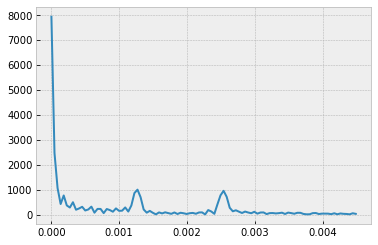

28.604845202824247 17.19110365955216 62.59798135130988


In [7]:
cept = np.fft.rfft(spect)
cept = np.abs(cept)
print(len(spect))

dt = freq_vector[1] - freq_vector[0]
freq_axis = np.fft.rfftfreq(len(spect), d=dt)

plt.plot(freq_axis[:100], cept[:100])
plt.show()

print(cept[99],cept[100],cept[101])

[ 4 28 56]


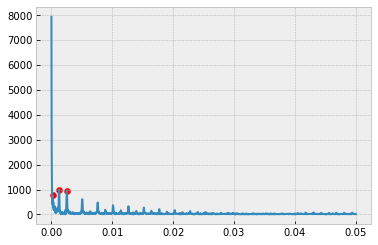

In [8]:
peaks = find_peaks(cept[1:], relative_threshold=.3) # ignore first max, that's the obvious peak
peaks += 1 # correction
peak_vals = cept[peaks]
print(peaks)

plt.plot(freq_axis, cept)
plt.scatter(freq_axis[peaks],peak_vals,color='r')
plt.show()

In [9]:
def parabolicInterpolationPeak(xs,ys):
#     print(xs,ys)
    [x1, x2, x3 ] = xs
    [y1, y2, y3 ] = ys
    denom = (x1 - x2) * (x1 - x3) * (x2 - x3)
    A     = (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2)) / denom
    B     = (x3*x3 * (y1 - y2) + x2*x2 * (y3 - y1) + x1*x1 * (y2 - y3)) / denom
    f = interp1d(xs,ys,kind='quadratic')
    x = -B / (2*A)
    return  (x,f(x))

In [10]:
quef_interped = interp1d(np.arange(len(freq_axis)), freq_axis)

largest_peak = np.argmax(cept[peaks]) # get index of largest peak 
rang = [peaks[largest_peak]-1, peaks[largest_peak], peaks[largest_peak]+1] # set up interp range
print(peaks[largest_peak])
# print(rang)
print([freq_axis[i] for i in rang])
px, py = parabolicInterpolationPeak(rang, [cept[i] for i in rang])

print(f"{quef_interped(px) = }")
f0_guess = 1/quef_interped(px)
print(f"{f0_guess = }")
print(f"{f0 = }")
print("Error:", np.abs(f0_guess - f0))

28
[0.0012239347234814144, 0.0012692656391659113, 0.0013145965548504081]
quef_interped(px) = array(0.00126075)
f0_guess = 793.1790880598194
f0 = 395
Error: 398.1790880598194


In [63]:
def cepstrum_f0_extraction(sig, display=True):
    sig = np.hanning(len(sig)) * sig # window func
    spect = np.fft.rfft(sig)
    spect = np.abs(spect)
    log_spect = np.log(spect)
    
    freq_axis = np.fft.rfftfreq(len(sig), d=1/SR)
    
    cept = np.fft.rfft(log_spect)
    cept = np.abs(cept)
    
    dt = freq_axis[1] - freq_axis[0]
    quef_axis = np.fft.rfftfreq(len(spect), d=dt)

    if display:
        plt.plot(quef_axis[:100], cept[:100])
        plt.show()
    
    peaks = find_peaks(cept[1:], relative_threshold=.2) # ignore first max, that's the obvious peak
    peaks += 1 # correction
    
    if display:
        plt.plot(quef_axis, cept)
        plt.scatter(quef_axis[peaks],cept[peaks],color='r')
        plt.show()
        
    
    quef_interped = interp1d(np.arange(len(quef_axis)), quef_axis)
    largest_peak = np.argmax(cept[peaks]) # get index of largest peak 
    rang = [peaks[largest_peak]-1, peaks[largest_peak], peaks[largest_peak]+1] # set up interp range
    px, py = parabolicInterpolationPeak(rang, [cept[i] for i in rang])
    
    f0_guess = 1/quef_interped(px)
    
    return f0_guess

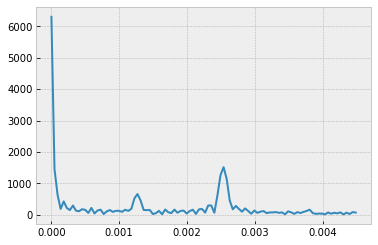

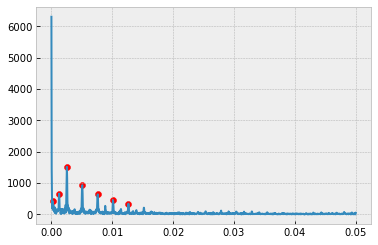

394.5853108827288


In [64]:
print(cepstrum_f0_extraction(X))

#### Now try for a bunch of f0's

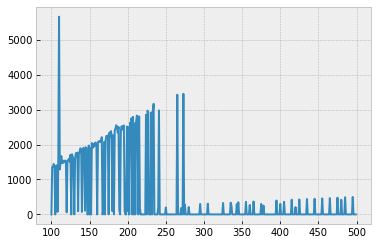

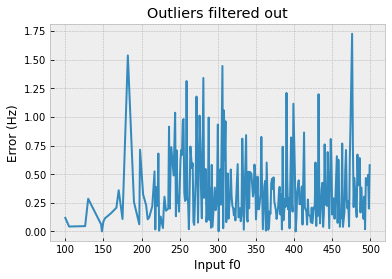

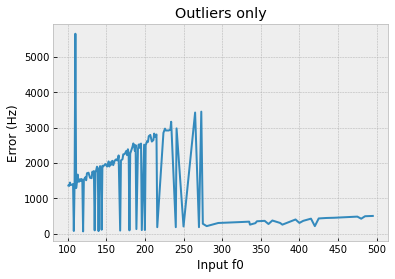

[101 102 103 104 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 127 128 129 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 149 151 153 154 155 156 157 158 159 161 162
 163 164 165 166 168 169 171 172 173 174 176 177 178 179 180 181 183 184
 185 186 187 188 189 191 192 193 194 195 196 199 200 201 203 204 205 207
 209 211 212 213 215 216 224 226 227 231 233 234 240 241 250 265 270 273
 275 280 295 305 325 335 336 343 345 355 360 365 375 378 395 400 405 415
 420 425 435 445 455 465 475 480 485 495]


In [53]:
f0_list = np.arange(100,500,1)

synthetic_spectra = [[(harm*f0, f0/(harm*f0), 0) for harm in range(1,20)] for f0 in f0_list]
sigs = [makeSignal(spectrum, duration=1/10, mode='relative', amp=1) for spectrum in synthetic_spectra]
# cepstrum_f0_extraction(sigs[0])
ran = range(len(sigs))

# blah = cepstrum_f0_extraction(sigs[3], display=True)

f0_guesses = [cepstrum_f0_extraction(sigs[sig], display=False) for sig in tqdm(ran)]

f0_errors = np.abs(f0_list - f0_guesses)
# print(f0_list)
# print(f0_guesses)
# print(f0_errors)

plt.plot(f0_list, f0_errors)
plt.show()

filtered = f0_errors < 50
plt.title("Outliers filtered out")
plt.plot(f0_list[filtered], f0_errors[filtered])
plt.xlabel("Input f0")
plt.ylabel("Error (Hz)")
plt.show()

filtered = f0_errors > 50
plt.title("Outliers only")
plt.plot(f0_list[filtered], f0_errors[filtered])
plt.xlabel("Input f0")
plt.ylabel("Error (Hz)")
plt.show()
print(f0_list[filtered])

### Now try the method of range-limiting (as in the blog post) but with interpolation 

In [101]:
def cepstrum_f0_extraction_range_interp(sig, display=True):
    sig = np.hanning(len(sig)) * sig # window func
    spect = np.fft.rfft(sig)
    spect = np.abs(spect)
    log_spect = np.log(spect)
    
    freq_axis = np.fft.rfftfreq(len(sig), d=1/SR)
    
    cept = np.fft.rfft(log_spect)
    cept = np.abs(cept)
    
    dt = freq_axis[1] - freq_axis[0]
    quef_axis = np.fft.rfftfreq(len(spect), d=dt)

    if display:
        plt.title("(Shortened) Cepstrum")
        plt.plot(quef_axis[:100], cept[:100])
        plt.show()
    
    fmin = 82
    fmax = 640
    valid_quefs = (quef_axis > 1/fmax) & (quef_axis < 1/fmin)
        
#     if display:
#         collection = collections.BrokenBarHCollection.span_where(quef_axis, ymin=0, ymax=cept.max(), where=valid_quefs, facecolor='green', alpha=0.5, label='valid pitches')
#         plt.plot(quef_axis, cept)
#         plt.collection(collection)
#         plt.show()
        
#     print(peaks)
    
    max_quef_index = np.argmax(cept[valid_quefs])
    f0_guess = 1/quef_axis[valid_quefs][max_quef_index] # guess without interp
    
    if display:
        plt.title("Argmax within valid range")
        plt.plot(quef_axis[:100], cept[:100])
        plt.scatter(quef_axis[valid_quefs][max_quef_index],cept[valid_quefs][max_quef_index],color='r')
        plt.show()

    quef_axis_valid = quef_axis[valid_quefs]
    cept_valid = cept[valid_quefs]
    quef_interped = interp1d(np.arange(len(quef_axis_valid)), quef_axis_valid)
    rang = [max_quef_index-1, max_quef_index, max_quef_index+1] # set up interp range
    px, py = parabolicInterpolationPeak(rang, [cept_valid[i] for i in rang])
    
#     f0_guess = 1/quef_interped(px)
    
    if display:
        plt.title("Interpolated max")
        plt.plot(quef_axis[:100], cept[:100])
        plt.scatter(quef_interped(px), cept_valid[max_quef_index], color='r')
        plt.show()
    
    return f0_guess

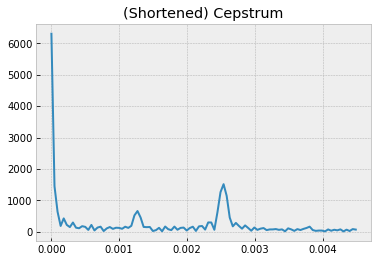

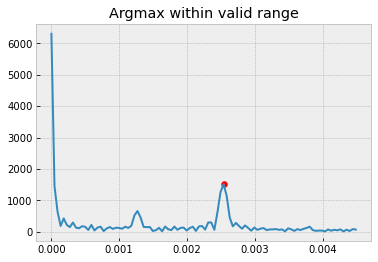

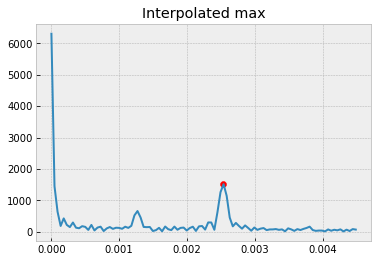

393.9285714285714


In [102]:
print(cepstrum_f0_extraction_range_interp(X))

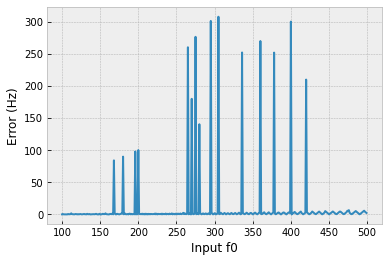

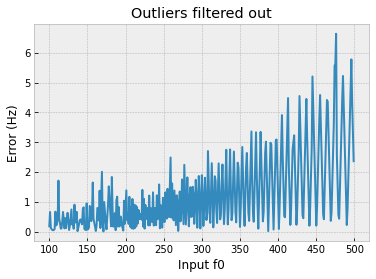

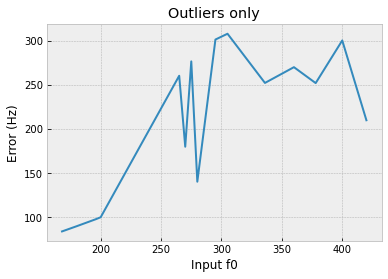

[168 180 196 200 265 270 275 280 295 305 336 360 378 400 420]


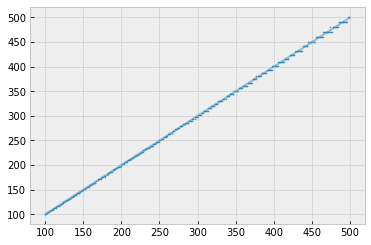

In [110]:
f0_list = np.arange(100,500,1)

synthetic_spectra = [[(harm*f0, f0/(harm*f0), 0) for harm in range(1,20)] for f0 in f0_list]
sigs = [makeSignal(spectrum, duration=1/10, mode='relative', amp=1) for spectrum in synthetic_spectra]
# cepstrum_f0_extraction(sigs[0])
ran = range(len(sigs))

# blah = cepstrum_f0_extraction(sigs[3], display=True)

f0_guesses = np.array([cepstrum_f0_extraction_range_interp(sigs[sig], display=False) for sig in tqdm(ran)])

f0_errors = np.abs(f0_list - f0_guesses)
# print(f0_list)
# print(f0_guesses)
# print(f0_errors)

plt.plot(f0_list, f0_errors)
plt.xlabel("Input f0")
plt.ylabel("Error (Hz)")
plt.show()

filtered = f0_errors < 50
plt.title("Outliers filtered out")
plt.plot(f0_list[filtered], f0_errors[filtered])
plt.xlabel("Input f0")
plt.ylabel("Error (Hz)")
plt.show()

filtered = f0_errors > 50
plt.title("Outliers only")
plt.plot(f0_list[filtered], f0_errors[filtered])
plt.xlabel("Input f0")
plt.ylabel("Error (Hz)")
plt.show()
print(f0_list[filtered])

filtered = f0_errors < 50
plt.scatter(f0_list[filtered], f0_guesses[filtered], s=1)
plt.plot(f0_list[filtered], f0_list[filtered], alpha=0.5)
plt.show()

Much better! What are all those outliers though...

###  Let's see how Yin compares

In [32]:
def find_valleys(A,absolute_threshold=0.1): 
    valleys = []
    for t in range(3,len(A)-1):             
        if A[t-1] > A[t] and A[t] < A[t+1] and A[t] < absolute_threshold:
            valleys.append(t)
    return np.array(valleys)

In [33]:
def Yin(X,t=0,window_size=2000,threshold=0.1, window_function=False, display=True):
    
    # normalize X to prevent overflow when multiplying
    X = np.array([x/MAX_AMP for x in X])

    W = window_size//2    # can only calculate lag times up to half of window size
    
    hann = np.hanning(W)
    
    X1 = X[t:(t+W)]       # stationary window of width W
    if window_function:
        X1 = hann * X1        # apply Hann window

    # Calculate d_t(tau),  p.1919
    
    if window_function:
        d_t = np.array([np.sum((X1 - (X[(tau+t):(tau+t+W)]*hann))**2) for tau in range(W)])
    else:
        d_t = np.array([np.sum((X1 - X[(tau+t):(tau+t+W)])**2) for tau in range(W)])
       
    # Calculate the cumulative mean normalized difference function d1_t(tau) = d'_t(tau)
    
    #  d1_t(tau) = 1 for tau = 0
    #            = d_t(tau) / mean(d_t(1), ..., d_t(tau))  otherwise
    #              = tau*d_t(tau)/(d_t(1)+ ... +d_t(tau))
    
    # Cumulative sum of [x0,x1,x2, .... ] is [x0, x0+x1, x0+x1+x2, ... ]
    # so this will calculate the denominator above:
    
    cumm_d_t = np.cumsum(d_t)
    
    d1_t = np.array([ 1 if (tau==0) else tau*d_t[tau]/cumm_d_t[tau] for tau in range(W)])

    # Now calculate minima in d1_t and find first one that is below
    # a fixed threshold; if none is below threshold, then choose overall global minimum
    
#     print(d1_t)
        
    V = find_valleys(d1_t)
      
    if V.size == 0:                     # used to be   if V == []
        tau = np.min(d1_t)
    else:
        tau = V[0]

 

    # Now improve this estimate by polynomial interpolation of three points that define
    # the minimum selected in the previous step
    # Code from http://stackoverflow.com/questions/717762/how-to-calculate-the-vertex-of-a-parabola-given-three-points
    
#     print(tau)
    
    tau = int(tau)
    x1 = tau-1
    y1 = d1_t[x1]
    x2 = tau
    y2 = d1_t[x2]
    x3 = tau+1
    y3 = d1_t[x3]
    

    A = (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2))   
    B = (x3**2 * (y1 - y2) + x2**2 * (y3 - y1) + x1**2 * (y2 - y3)) 
    
    bestTau = - B/(2*A)
    
#  This will display the difference function
    if display:
#         displaySignal(X1 ,title="Signal Window",xUnits="Samples",yUnits="Absolute")
#         displaySignal(d_t ,title="Difference Function",xUnits="Samples",yUnits="Absolute")
#         displaySignal(d1_t ,title="Normalized Difference Function",xUnits="Samples",yUnits="Absolute")
        
        plt.figure(figsize=(12,6))
        plt.title("Signal Window")
        plt.plot(X1)
        plt.show()
        
        plt.figure(figsize=(12,6))
        plt.title("Difference Function")
        plt.plot(d_t)
        plt.show()
        
        plt.figure(figsize=(12,6))
        plt.title("Normalized Difference Function")
        plt.plot(d1_t)
        plt.show()

    return (44100.0/bestTau)

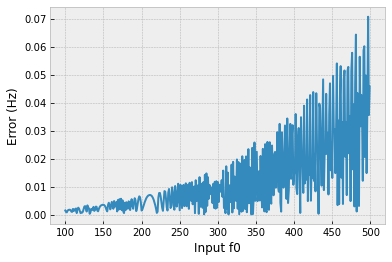

In [35]:
f0_list = np.arange(100,500,1)

synthetic_spectra = [[(harm*f0, f0/(harm*f0), 0) for harm in range(1,20)] for f0 in f0_list]
sigs = [makeSignal(spectrum, duration=1/10, mode='relative', amp=1) for spectrum in synthetic_spectra]
# cepstrum_f0_extraction(sigs[0])
ran = range(len(sigs))

# blah = cepstrum_f0_extraction(sigs[3], display=True)

f0_guesses = [Yin(sigs[sig], display=False) for sig in tqdm(ran)]

f0_errors = np.abs(f0_list - f0_guesses)
# print(f0_list)
# print(f0_guesses)
# print(f0_errors)

plt.plot(f0_list, f0_errors)
plt.xlabel("Input f0")
plt.ylabel("Error (Hz)")
plt.show()

# plt.plot(f0_errors[f0_errors < 10])
# plt.show()

# Spectrum Extraction & Tone Generation

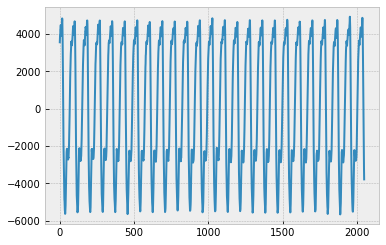

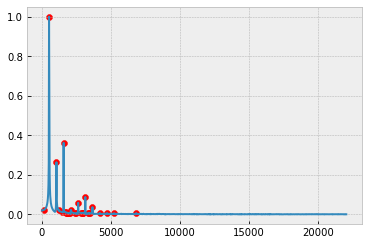

In [14]:
clar = readWaveFile("clarinet_C5.wav")
frame_size = 2048

plt.plot(clar[len(clar)//2:len(clar)//2+frame_size])
plt.show()

spect = np.fft.rfft(clar[len(clar)//2:len(clar)//2+frame_size])
spect = np.abs(spect)
log_spect = np.log(spect)
spect = spect/np.max(spect) # normalize

peaks = find_peaks(spect, relative_threshold=.023) #kinda good
peaks = find_peaks(spect, relative_threshold=.005)

freq_axis = np.fft.rfftfreq(frame_size, d=1/SR)

# peaks, props = scipy.signal.find_peaks(spect, threshold=10000)

# filt = scipy.signal.butter(10, Wn=100, btype="highpass", fs=SR, output="sos")
plt.plot(freq_axis, spect)
# plt.plot(scipy.signal.sosfilt(filt, spect))
plt.scatter(freq_axis[peaks],spect[peaks],color='r')
plt.show()
Audio(clar, rate=SR)

In [15]:
def get_ratios(X):
    intervals = []
    for i in range(len(X)):
        intervals.append(X[i]/X[0])
        
    return np.array(intervals)

In [16]:
peaks = peaks[1:] # dumb correction DONT FORGET ABOUT THIS
ratios = get_ratios(peaks)
print(peaks)
print(ratios)

f0 = Freqs['C5']
spect_freqs = ratios*f0
spect_amps = spect[peaks]
harms = list(zip(spect_freqs, spect_amps))
print(harms)
components = [(f, a, 0) for f,a in harms]

signal = makeSignal(components)
Audio(signal, rate=SR)

[ 24  49  57  69  73  77  80  82  84  86  89  91  93  98 111 115 122 132
 134 137 139 146 155 158 161 170 195 219 243 317]
[ 1.          2.04166667  2.375       2.875       3.04166667  3.20833333
  3.33333333  3.41666667  3.5         3.58333333  3.70833333  3.79166667
  3.875       4.08333333  4.625       4.79166667  5.08333333  5.5
  5.58333333  5.70833333  5.79166667  6.08333333  6.45833333  6.58333333
  6.70833333  7.08333333  8.125       9.125      10.125      13.20833333]
[(523.2511306011983, 1.0), (1068.3043916441131, 0.2639821223704314), (1242.721435177846, 0.02238899650009172), (1504.3470004784451, 0.011530969469586563), (1591.5555222453113, 0.3624241060853267), (1678.764044012178, 0.012999495705324784), (1744.1704353373277, 0.011311795494389583), (1787.7746962207607, 0.009735071739396617), (1831.378957104194, 0.009525941017566635), (1874.9832179876273, 0.008221913029138671), (1940.3896093127769, 0.007764240241756015), (1983.99387019621, 0.007821810911079325), (2027.59813107964

In [17]:
f0 = Freqs['A4']
ratios = ratios.astype(int) # cast to int cause... harmonics are integer multiples and... yeah
spect_freqs = ratios*f0
spect_amps = spect[peaks]
harms = list(zip(spect_freqs, spect_amps))
print(harms)
components = [(f, a, 0) for f,a in harms]

signal = makeSignal(components)
Audio(signal, rate=SR)

[(440.0000000000008, 1.0), (880.0000000000016, 0.2639821223704314), (880.0000000000016, 0.02238899650009172), (880.0000000000016, 0.011530969469586563), (1320.0000000000023, 0.3624241060853267), (1320.0000000000023, 0.012999495705324784), (1320.0000000000023, 0.011311795494389583), (1320.0000000000023, 0.009735071739396617), (1320.0000000000023, 0.009525941017566635), (1320.0000000000023, 0.008221913029138671), (1320.0000000000023, 0.007764240241756015), (1320.0000000000023, 0.007821810911079325), (1320.0000000000023, 0.006955214029073653), (1760.0000000000032, 0.023611171332081952), (1760.0000000000032, 0.006952849003787441), (1760.0000000000032, 0.006102204140930005), (2200.000000000004, 0.05870519946916356), (2200.000000000004, 0.007807874372804121), (2200.000000000004, 0.007812437535576838), (2200.000000000004, 0.008107968477180524), (2200.000000000004, 0.007884771456372149), (2640.0000000000045, 0.08822967234670587), (2640.0000000000045, 0.0056241058712419535), (2640.0000000000045

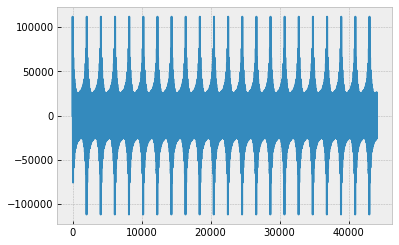

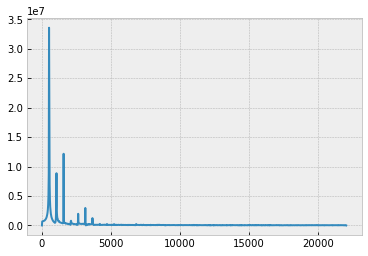

In [18]:
components = [(freq_axis[i], spect[i], 0) for i in range(len(spect))]
signal = makeSignal(components)
plt.plot(signal)
plt.show()

spect = np.fft.rfft(signal[len(signal)//2:len(signal)//2+frame_size])
spect = np.abs(spect)
plt.plot(freq_axis, spect)
plt.show()

Audio(signal, rate=SR)

In [19]:
list(zip([1,2,3], [4,5,6]))

[(1, 4), (2, 5), (3, 6)]